In [13]:
# Module Import
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import json
from IPython.display import display
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    GRU, LSTM, Bidirectional,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention, Add
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tcn import TCN

In [14]:
# 데이터 전처리
data = pd.read_csv("../frontend/public/sensor.csv")

all_zero_cols = data.columns[(data == 0).all()].tolist()
all_nan_cols = data.columns[data.isna().all()].tolist()
threshold = 1.2
low_std_cols = data.std(numeric_only=True).loc[lambda x: x < threshold].index.tolist()
useless_columns = list(set(all_zero_cols + all_nan_cols + low_std_cols))
data = data.drop(columns=useless_columns)

status_map = {'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}
data['machine_status_encoded'] = data['machine_status'].map(status_map)

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data.interpolate(method='time')

sensor_cols = [col for col in data.columns if col.startswith('sensor')]
scaler = StandardScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])

data = data.drop(columns=['machine_status'])
data = data.sort_index()
data.columns

C:\Users\LEETJ\AppData\Local\Temp\ipykernel_20196\1390813879.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='time')


Index(['Unnamed: 0', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_19', 'sensor_20', 'sensor_21',
       'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26',
       'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31',
       'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36',
       'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41',
       'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46',
       'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51',
       'machine_status_encoded'],
      dtype='object')

In [15]:
# 데이터 분할 학습(60%), 테스트(40%)
total_rows = len(data)
split_idx = int(total_rows * 0.6)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(total_rows)
print(len(train_data))
print(len(test_data))

220320
132192
88128


In [16]:
# 상태 예측 window 생성
def create_windows_fast(data, window_size=60, step=1, label_col='machine_status_encoded'):
    sensor_cols = [col for col in data.columns if col.startswith('sensor')]
    sensor_data = data[sensor_cols].to_numpy(dtype=np.float32)
    label_data = data[label_col].to_numpy(dtype=np.int8)

    num_windows = (len(sensor_data) - window_size) // step
    X = np.empty((num_windows, window_size, len(sensor_cols)), dtype=np.float32)
    y = np.empty(num_windows, dtype=np.int8)

    for i in range(num_windows):
        idx = i * step
        X[i] = sensor_data[idx:idx + window_size]
        y[i] = label_data[idx + window_size]

    return X, y

X_train, y_train = create_windows_fast(train_data)
X_test, y_test = create_windows_fast(test_data)

In [17]:
# 모델 학습
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)

xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_xgb=y_pred

report_xgb = classification_report(
    y_test, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)

# LightGBM
lgbm_model = lgb.LGBMClassifier(
    n_estimators      = 200,
    max_depth        = -1,
    learning_rate    = 0.05,
    num_leaves       = 64,
    objective        = 'multiclass',
    class_weight     = None,
    subsample        = 0.8,
    colsample_bytree = 0.8,
    n_jobs           = -1,
    random_state     = 42
)

lgbm_model.fit(
    X_train.reshape(X_train.shape[0], -1),
    y_train
)

y_pred = lgbm_model.predict(
    X_test.reshape(X_test.shape[0], -1)
)
y_pred_lgbm=y_pred

report_lgbm = classification_report(
    y_test, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)

# 1D-CNN
y_train_cnn = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cnn = tf.keras.utils.to_categorical(y_test, num_classes=3)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(
    X_train, y_train_cnn,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

y_pred_proba = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)
y_pred_cnn=y_pred

report_cnn = classification_report(
    y_true, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)

# LSTM
y_train_lstm = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_lstm = tf.keras.utils.to_categorical(y_test, num_classes=3)

lstm_model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train_lstm,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

y_pred_proba = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)
y_pred_lstm=y_pred

report_lstm = classification_report(
    y_true, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)

c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.046558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733380
[LightGBM] [Info] Number of data points in the train set: 132132, number of used features: 2940
[LightGBM] [Info] Start training from score -0.079739
[LightGBM] [Info] Start training from score -2.569090
[LightGBM] [Info] Start training from score -10.182119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classif

Epoch 1/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9789 - loss: 0.0648 - val_accuracy: 0.6129 - val_loss: 2.4983
Epoch 2/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9986 - loss: 0.0039 - val_accuracy: 0.9145 - val_loss: 0.5508
Epoch 3/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 0.8527 - val_loss: 1.0500
Epoch 4/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.7573 - val_loss: 1.1253
Epoch 5/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.8999 - val_loss: 0.4591
Epoch 6/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.8742 - val_loss: 1.0728
Epoch 7/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.8836 - val_loss: 0.8244
Epoch 8/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9994 - loss: 0.0020 - 

c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Epoch 1/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9453 - loss: 0.1619 - val_accuracy: 0.9695 - val_loss: 0.0975
Epoch 2/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 59s 71ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9230 - val_loss: 0.1717
Epoch 3/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9085 - val_loss: 0.2382
Epoch 4/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 0.8213 - val_loss: 0.8220
Epoch 5/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.8313 - val_loss: 0.9821
Epoch 6/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 59s 71ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.7560 - val_loss: 0.9594
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step


c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\buSKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [18]:
# 전체 예측 F1-score 비교
df_xgb = pd.DataFrame(report_xgb).T
print("\n[XGBoost Classification Report]")
display(df_xgb)

df_lgbm = pd.DataFrame(report_lgbm).T
print("\n[LightGBM Classification Report]")
display(df_lgbm)

df_cnn = pd.DataFrame(report_cnn).T
print("\n[1D-CNN Classification Report]")
display(df_cnn)

df_lstm = pd.DataFrame(report_lstm).T
print("\n[LSTM Classification Report]")
display(df_lstm)


[XGBoost Classification Report]


,precision,recall,f1-score,support
NORMAL,0.999916,0.995953,0.997931,83771.00000
RECOVERING,0.926550,0.998603,0.961228,4295.00000
BROKEN,0.000000,0.000000,0.000000,2.00000
accuracy,0.996060,0.996060,0.996060,0.99606
macro avg,0.642155,0.664852,0.653053,88068.00000
weighted avg,0.996315,0.996060,0.996118,88068.00000



[LightGBM Classification Report]


,precision,recall,f1-score,support
NORMAL,0.998979,0.981533,0.990179,83771.00000
RECOVERING,0.731424,0.980908,0.837991,4295.00000
BROKEN,0.000000,0.000000,0.000000,2.00000
accuracy,0.981480,0.981480,0.981480,0.98148
macro avg,0.576801,0.654147,0.609390,88068.00000
weighted avg,0.985908,0.981480,0.982735,88068.00000



[1D-CNN Classification Report]


,precision,recall,f1-score,support
NORMAL,0.999483,0.991942,0.995698,83771.000000
RECOVERING,0.863055,0.990454,0.922376,4295.000000
BROKEN,0.000000,0.000000,0.000000,2.000000
accuracy,0.991847,0.991847,0.991847,0.991847
macro avg,0.620846,0.660799,0.639358,88068.000000
weighted avg,0.992807,0.991847,0.992100,88068.000000



[LSTM Classification Report]


,precision,recall,f1-score,support
NORMAL,0.999405,0.981963,0.990607,83771.000000
RECOVERING,0.737454,0.988824,0.844838,4295.000000
BROKEN,0.000000,0.000000,0.000000,2.000000
accuracy,0.982275,0.982275,0.982275,0.982275
macro avg,0.578953,0.656929,0.611815,88068.000000
weighted avg,0.986607,0.982275,0.983475,88068.000000


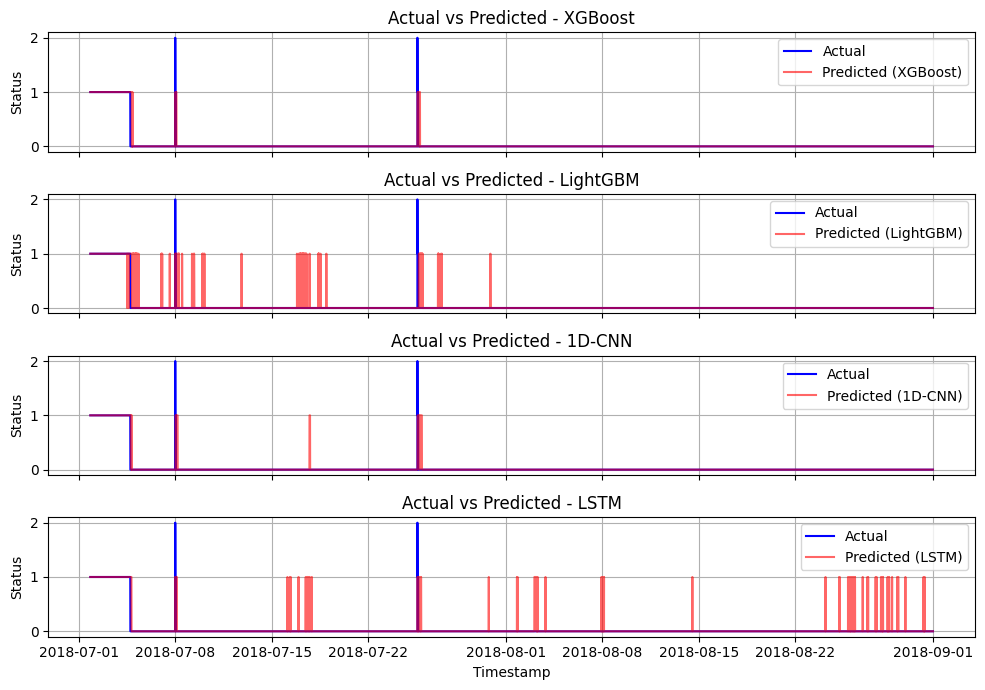

In [19]:
# 전체 예측 결과 차트로 비교
window_size = 60
timestamps = test_data.index[window_size:]

df_plot = pd.DataFrame({
    "timestamp": timestamps,
    "actual": y_test.flatten(),
    "XGBoost": y_pred_xgb,
    "LightGBM": y_pred_lgbm,
    "1D-CNN": y_pred_cnn,
    "LSTM": y_pred_lstm
})

model_names = ['XGBoost', 'LightGBM', '1D-CNN', 'LSTM']
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True)

for i, model in enumerate(model_names):
    axes[i].plot(df_plot["timestamp"], df_plot["actual"], color="blue", label="Actual")
    axes[i].plot(df_plot["timestamp"], df_plot[model], color="red", alpha=0.6, label=f"Predicted ({model})")
    axes[i].set_ylabel("Status")
    axes[i].set_title(f"Actual vs Predicted - {model}")
    axes[i].grid(True)
    axes[i].legend(loc="upper right")

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()

In [20]:
# RECOVERING 시점 데이터
window_size = 60
train_timestamps = train_data.index.to_series().reset_index(drop=True)
test_timestamps = test_data.index[window_size:]

train_labels = train_data["machine_status_encoded"].values
train_rec_times = train_timestamps[(train_labels == 1)].astype(str).tolist()

test_rec_times = test_timestamps[(y_pred_xgb == 1)].astype(str).tolist()

all_rec_times = sorted(set(train_rec_times + test_rec_times))

for t in all_rec_times:
    print(t)


2018-04-12 21:56:00
2018-04-12 21:57:00
2018-04-12 21:58:00
2018-04-12 21:59:00
2018-04-12 22:00:00
2018-04-12 22:01:00
2018-04-12 22:02:00
2018-04-12 22:03:00
2018-04-12 22:04:00
2018-04-12 22:05:00
2018-04-12 22:06:00
2018-04-12 22:07:00
2018-04-12 22:08:00
2018-04-12 22:09:00
2018-04-12 22:10:00
2018-04-12 22:11:00
2018-04-12 22:12:00
2018-04-12 22:13:00
2018-04-12 22:14:00
2018-04-12 22:15:00
2018-04-12 22:16:00
2018-04-12 22:17:00
2018-04-12 22:18:00
2018-04-12 22:19:00
2018-04-12 22:20:00
2018-04-12 22:21:00
2018-04-12 22:22:00
2018-04-12 22:23:00
2018-04-12 22:24:00
2018-04-12 22:25:00
2018-04-12 22:26:00
2018-04-12 22:27:00
2018-04-12 22:28:00
2018-04-12 22:29:00
2018-04-12 22:30:00
2018-04-12 22:31:00
2018-04-12 22:32:00
2018-04-12 22:33:00
2018-04-12 22:34:00
2018-04-12 22:35:00
2018-04-12 22:36:00
2018-04-12 22:37:00
2018-04-12 22:38:00
2018-04-12 22:39:00
2018-04-12 22:40:00
2018-04-12 22:41:00
2018-04-12 22:42:00
2018-04-12 22:43:00
2018-04-12 22:44:00
2018-04-12 22:45:00
